# Digital homo- and heterodyne detection

In [136]:
import matplotlib.pyplot as plt
import itertools
import numpy as np
import os
from scipy.stats import kstest
from scipy.interpolate import interp1d
from random import choices
from joblib import Parallel, delayed
from tqdm import tqdm
from scipy.integrate import quad
from scipy.special import factorial, eval_hermite, comb
import cvxpy as cp

from qutip import *

## Define operators

In [3]:
N=2

idc = qeye(N)
ida = qeye(2)
N_cav = tensor(num(N), ida)

a  = tensor(destroy(N), ida)
sm = tensor(idc, destroy(2)) # note that this is not qutip's sigmam() definition

sx = tensor(idc, sigmax())
sy = tensor(idc, sigmay())
sz = tensor(idc, sigmaz())

proj0 = tensor(idc, basis(2,0).proj())
proj1 = tensor(idc, basis(2,1).proj())

In [4]:
def interact(g):
    op = (-1j) * g * (a.dag() * sm + a * sm.dag())
    return op.expm() 

def rotateX(theta):
    op = (-1j) * (theta/2) * sx
    return op.expm()

def rotateY(theta):
    op = (-1j) * (theta/2) * sy
    return op.expm()

def rotateXY(theta,rotangl):
    op = (-1j) * (theta/2) * (np.cos(rotangl)* sx + np.sin(rotangl)* sy)
    return op.expm()

def interact(g):
    op = (-1j) * g * (a.dag() * sm + a * sm.dag())
    return op.expm() 

def H_int(g, dt):
    Hint =   g*np.sqrt(dt) * (a.dag() * sm - a * sm.dag())
    return Hint.expm()


def U_swap(theta):
    H = -1j*theta*(a.dag() * sm + a * sm.dag())
    return H.expm()

## Params

0.282842712474619

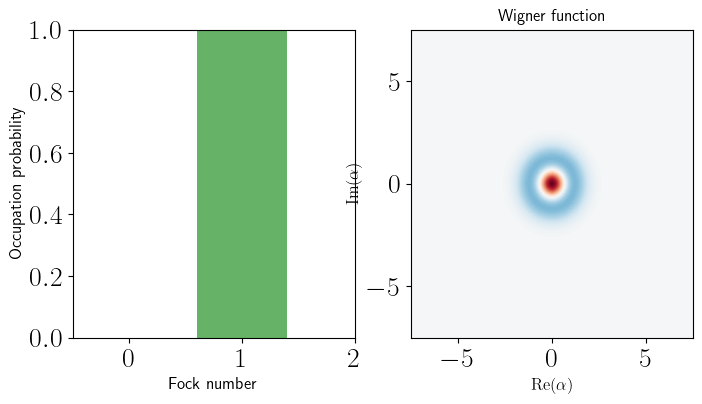

In [7]:
# number of qubit measurements per trajectory
Nmeas = 50

# number of trajectories
Ntrajs = 1000

# interaction strength
g = 4
delta_t = 0.005
dt = delta_t

gamma = g**2

gint = np.sqrt(gamma*delta_t)

theta = gint

rotangl = np.pi/2 # homodyne angle

# initialize state: cavity in coherent state, qubit in ground state 
alphain = 2
#initial_cavity = (fock(N, 0) + fock(N,4)).unit()
initial_cavity = (coherent(N, alphain) + coherent(N,-alphain)).unit()
initial_cavity= fock(N,1)

psi0 = tensor(initial_cavity, basis(2,0))

plot_wigner_fock_distribution(initial_cavity);

theta

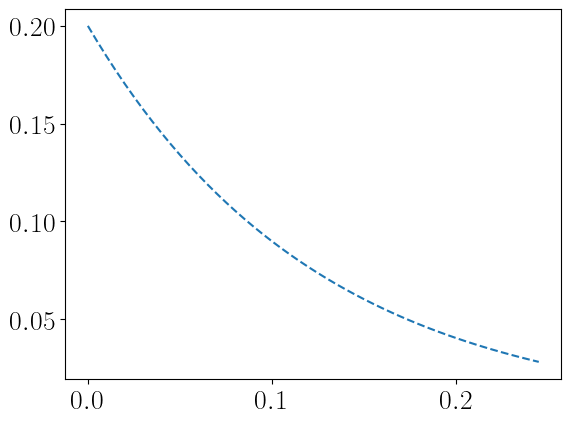

In [8]:
### Plot

nsteps = np.linspace(0,Nmeas-1,Nmeas)
weights=(gint/np.sqrt(2))*np.exp(-nsteps*(gint**2/2))
                                   
tlist = nsteps*delta_t
plt.plot(tlist,weights,'--');

In [12]:
# histogram settings
k = 5 # histogram bin limit
Nbins = 55

# ideal distribution from Wigner marginal
x=np.linspace(-k,k,200)
dx = np.diff(x)[0]
W = wigner(initial_cavity, x, x)

marginal = np.trapz(W,x)

# ideal cdf from marginal
cdf = np.cumsum(marginal)*dx
cdf_func = interp1d(x, cdf, fill_value="extrapolate")

#seed
prng = np.random.RandomState(73885327)
rnd = np.random.RandomState(61358529)

# System with no dissipation

In [13]:
# theta: effective interaction strength 
# correct_prob: probability of correct qubit measurement
def get_measurements(Ntrajs, theta, correct_prob):
    U_int = U_swap(theta)
    
    ### simulate tomography ###
    
    qbrotmat = rotateXY(np.pi/2,rotangl) # qb rotation applied prior to qb measurement, defines measured homodyne quadrature
    
    qbfeedback = rotateX(np.pi) # this pulse will reset the qubit if found in the excited state
    measurements = []

    for j in range(Ntrajs):
        xrnd = prng.rand(Nmeas)
        error = rnd.rand(Nmeas)

        results = []
        psi = psi0

        for i in range(Nmeas):
            psi = qbrotmat * (U_int * psi)

            prob = expect(proj0,psi) # prob to be in gs
            if prob>xrnd[i]:
                # measured g
                results.append(-1 if error[i] <= correct_prob else 1) 
                #results.append(-1) correct result
                psi = (proj0 * psi).unit()
            else:
                results.append(1 if error[i] <= correct_prob else -1)
                #results.append(1) correct result
                # measured e
                psi = (proj1 * psi).unit()
                # go back to g
                psi = qbfeedback * psi

        measurements.append(np.sum(results*weights))

    # return measurement result and final vacuum population
    return measurements, psi.ptrace(0)[0,0].real   

### Test measurement

0.05220048358283644

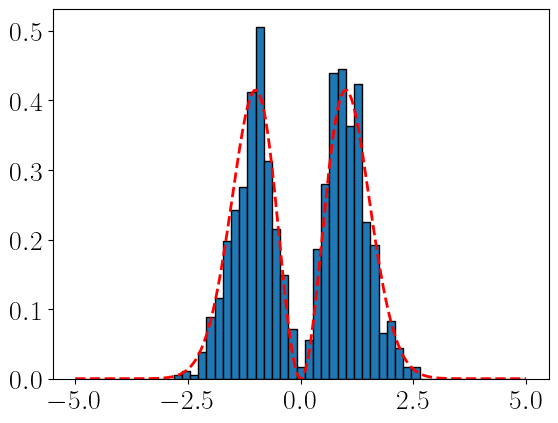

In [14]:
measurements, f_cavity_vac = get_measurements(Ntrajs, 0.3, 1)
    

plt.hist(measurements,Nbins,[-5,5], density=True, edgecolor='k')
plt.plot(x,marginal, 'r--',linewidth=2, label='$W$ marginal')

ks_stat = kstest(measurements, cdf_func)[0]
ks_stat

# Check qubit readout error

In [15]:
# compare histograms

# 50 % correct readout probability: completely random, should correspond to vacuum measurement
prob_50 = 0.5 
measurements_50, _ = get_measurements(Ntrajs, theta, prob_50)

# 80 % correct readout probability
prob_80 = 0.80
measurements_80, _ = get_measurements(Ntrajs, theta, prob_80)

# 90 % correct readout probability
prob_90 = 0.90
measurements_90, _ = get_measurements(Ntrajs, theta, prob_90)

# 95 % correct readout probability
prob_95 = 0.95
measurements_95, _ = get_measurements(Ntrajs, theta, prob_95)

# 100 % correct readout probability:
prob_100 = 1
measurements_100, _ = get_measurements(Ntrajs, theta, prob_100)

(0.25468831577013096, 0.024585978875732273)

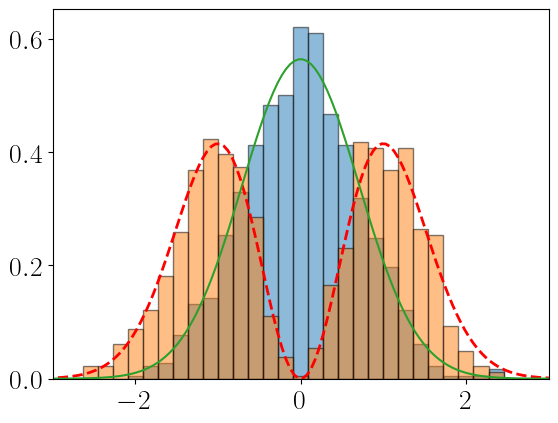

In [17]:
hist, bins, _ = plt.hist(measurements_50,Nbins,[-k,k], density=True, alpha=0.5, edgecolor='k')
hist, bins, _ = plt.hist(measurements_100,Nbins,[-k,k], density=True, alpha=0.5, edgecolor='k')

plt.plot(x,marginal, 'r--',linewidth=2, label='$W$ marginal')
plt.plot(x, np.abs(np.exp(-x**2/2)*(1/np.pi)**(1/4))**2) # vacuum

plt.xlim([-3,3])

ks_stat_50 = kstest(measurements_50, cdf_func)[0]
ks_stat_100 = kstest(measurements_100, cdf_func)[0]
ks_stat_50, ks_stat_100

## Loop over probabilities

In [18]:
%%time

# seeds for random number generation


# probability of correct readout
prob_list = np.linspace(0.80, 1.0, 9)

list_mean_ks_prob = []

nr_stats =  1 # number of times to run statistics

def get_stats_func():
    measurements, f_cavity_vac = get_measurements(Ntrajs, theta, prob)
    ks_stat = kstest(measurements, cdf_func)[0]
    return ks_stat

for idx, prob in enumerate(prob_list):
    print(prob)
    
    ks_stats = Parallel(n_jobs=nr_stats, backend="loky")(delayed(get_stats_func)() for i in range(nr_stats))
    mean_ks = np.mean(ks_stats)
        
    list_mean_ks_prob.append(mean_ks)

0.8
0.8250000000000001
0.8500000000000001
0.875
0.9
0.925
0.95
0.975
1.0
CPU times: user 425 ms, sys: 117 ms, total: 541 ms
Wall time: 2min 13s


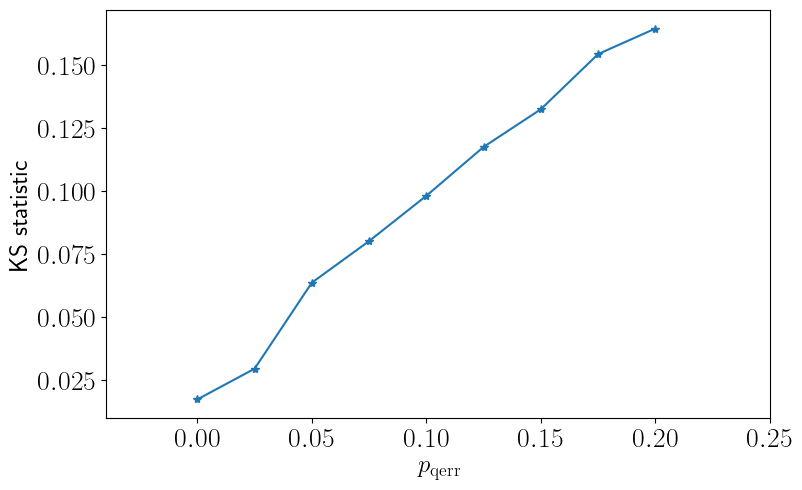

In [121]:
fig, ax = plt.subplots(figsize=(8,5))
error_prob = 1 - prob_list
ax.plot(error_prob, list_mean_ks_prob,'*-')
plt.ylabel(r'KS statistic')
plt.xlabel('$p_\mathrm{qerr}$')
plt.xlim([-0.04,0.25])
plt.tight_layout()
plt.savefig('KS_qubit_error_prob_wide.pdf')
#ax.invert_xaxis()

In [23]:
#np.savetxt('homodyne_fock1_Nmeas50_Ntrajs1000_prob10_g4_dt0.005_loopProb.dat', np.c_[prob_list, list_mean_ks_prob], header='prob ks')

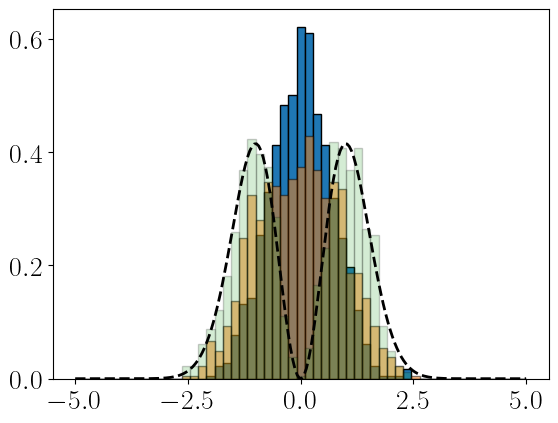

In [34]:
hist, bins, _ = plt.hist(measurements_50,Nbins,[-k,k], density=True, alpha=1, edgecolor='k')
hist, bins, _ = plt.hist(measurements_80,Nbins,[-k,k], density=True, alpha=0.5, edgecolor='k')
hist, bins, _ = plt.hist(measurements_100,Nbins,[-k,k], density=True, alpha=0.2, edgecolor='k')
#hist, bins, _ = plt.hist(measurements_100,Nbins,[-k,k], density=True, alpha=0.5, edgecolor='k')
#plt.plot(x,marginal, 'r--',linewidth=2, label='$W$ marginal')
#plt.plot(x, np.abs(np.exp(-x**2/2)*(1/np.pi)**(1/4))**2) # vacuum
plt.plot(x,marginal, 'k--',linewidth=2, label='$W$ marginal')

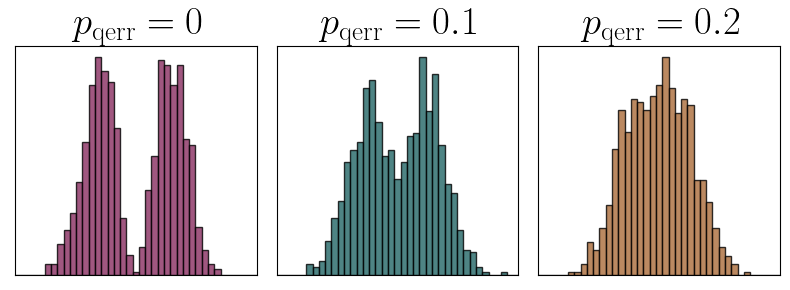

In [113]:
fig, ax = plt.subplots(1,3, figsize=(8,3))
l=3.5
font = 28
ax[0].hist(measurements_100,Nbins,[-k,k], density=True, alpha=0.8, edgecolor='k', color='#882D60');
#ax[0].plot(x,marginal, '-',color='#A5C663', linewidth=3, label='$W$ marginal');
ax[0].set_title('$p_\mathrm{qerr}=0$',fontsize=font)
ax[0].set_xlim([-l,l])
ax[0].set_yticks([])
ax[0].set_xticks([])

ax[1].hist(measurements_90,Nbins,[-k,k], density=True, alpha=0.8, edgecolor='k', color='#226666');
ax[1].set_title('$p_\mathrm{qerr}=0.1$',fontsize=font)
ax[1].set_xlim([-l,l])
ax[1].set_yticks([])
ax[1].set_xticks([])

ax[2].hist(measurements_80,Nbins,[-k,k], density=True, alpha=.8, edgecolor='k', color='#AA6C39');
ax[2].set_title('$p_\mathrm{qerr}=0.2$',fontsize=font)
ax[2].set_xlim([-l,l])
ax[2].set_yticks([])
ax[2].set_xticks([])
a#x[2].hist(measurements_50,Nbins,[-k,k], density=True, alpha=0.3, edgecolor='k');
#ax[2].plot(x, np.abs(np.exp(-x**2/2)*(1/np.pi)**(1/4))**2, 'r--');
plt.tight_layout()
plt.savefig('qubit_error_prob_hists.pdf')

# test tomography

In [154]:
# theta: effective interaction strength 
# correct_prob: probability of correct qubit measurement
def get_measurements_tomo(Ntrajs, theta, correct_prob,rotangl):
    U_int = U_swap(theta)
    
    ### simulate tomography ###
    
    qbrotmat = rotateXY(np.pi/2,rotangl) # qb rotation applied prior to qb measurement, defines measured homodyne quadrature
    
    qbfeedback = rotateX(np.pi) # this pulse will reset the qubit if found in the excited state
    measurements = []

    for j in range(Ntrajs):
        xrnd = prng.rand(Nmeas)
        error = rnd.rand(Nmeas)

        results = []
        psi = psi0

        for i in range(Nmeas):
            psi = qbrotmat * (U_int * psi)

            prob = expect(proj0,psi) # prob to be in gs
            if prob>xrnd[i]:
                # measured g
                results.append(-1 if error[i] <= correct_prob else 1) 
                #results.append(-1) correct result
                psi = (proj0 * psi).unit()
            else:
                results.append(1 if error[i] <= correct_prob else -1)
                #results.append(1) correct result
                # measured e
                psi = (proj1 * psi).unit()
                # go back to g
                psi = qbfeedback * psi

        measurements.append(np.sum(results*weights))
    
    ### create histogram ###    
    hist, bins = np.histogram(measurements,Nbins,[-k,k], density=True)
    
    return hist  

In [223]:
# homodyne angles for tomography
nangles = 10 # number of angles
thetas = np.linspace(0,np.pi, nangles) # list of all angles


# histogram parameters
Nbins = 30 # number of histogram bins
k = 4  # bin edge limit
dx =  2*k/Nbins # bin width


prob_correct = 0.92
eta = 4*(prob_correct - 0.5)**2 
eta

0.7056000000000001

In [224]:
b_all = Parallel(n_jobs=-1, verbose=5, backend="loky")(delayed( get_measurements_tomo)(Ntrajs, theta, prob_correct, rotangle) for rotangle in thetas)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:   14.7s remaining:   22.0s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   15.0s remaining:    6.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   15.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   15.3s finished


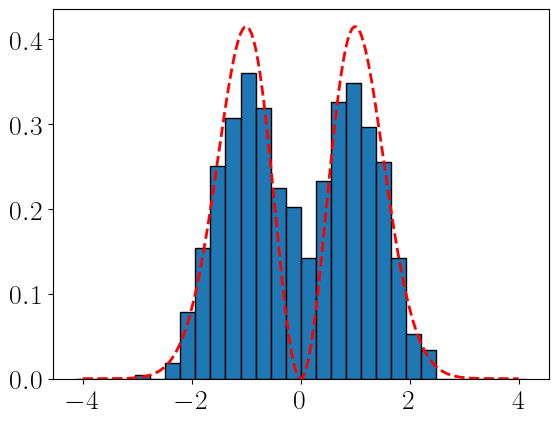

In [225]:
x_hist = np.linspace(-k,k,Nbins)
width = np.diff(x_hist)[3]
histogram = b_all[1]

plt.bar(x_hist,histogram , align='center', width=width, edgecolor='k',label='Samples' );

# ideal distribution from Wigner marginal
x=np.linspace(-k,k,200)
dx = np.diff(x)[0]
W = wigner(initial_cavity, x, x)

marginal = np.trapz(W,x)

# ideal cdf from marginal
cdf = np.cumsum(marginal)*dx
cdf_func = interp1d(x, cdf, fill_value="extrapolate")

plt.plot(x,marginal, 'r--',linewidth=2, label='$W$ marginal');

### Prepare data and operators

In [226]:
N_large = 25 # need some additional dimensions to properly construct the noise-compensated operators

# Load homodyne data into vector $\vec b$
b = np.concatenate([array for array in b_all])

### Define the harmonic oscillator wavefunction
#To create homodyne POVM operators.

def wavefunction(x,n):
    const = 1/(np.sqrt(2**n * factorial(n)) * (np.pi)**0.25 )
    rest = const* np.exp(-x**2/2)
    return float(rest*eval_hermite(n,x))

### Construct measurement operators
def get_Pis(theta, i):
    Pi = np.zeros((N_large,N_large),dtype=np.complex128)
    for m in range(N_large):
        wave_m = lambda x : wavefunction(x, m)
        for n in range(N_large):
            wave_n = lambda x: wavefunction(x, n)            
            func = lambda x: wave_m(x)*wave_n(x)
            Pi[n,m] = quad(func, -k + i*dx, -k + (i+1)*dx)[0]*np.exp(-1j*(n-m)*theta)
            
    return Pi*2 #

Pis = Parallel(n_jobs=16, verbose=5, backend="multiprocessing")(delayed(get_Pis)(theta,i) for theta in thetas for i in range(Nbins))

#The list `basis_dms` contains all $\Omega_k$
# funtions to construct vectors
def get_basis_vectors(N_large):
    # construct vectors
    basis_vectors = []
    for i in range(N_large):
        vector = fock(N_large, i)
        basis_vectors.append(np.real(vector.full()))
    
    return basis_vectors
        
def get_basis_dms(N_large, basis_vectors):    
    # construct operators
    basis_dms = []
    for vector1 in basis_vectors:
        for vector2 in basis_vectors:
            dm = np.outer(vector1, vector2)
            basis_dms.append(dm)
            
    return basis_dms

basis_vectors  = get_basis_vectors(N_large) # needed for the adjusted operators
basis_dms = get_basis_dms(N_large, basis_vectors)
        
### Construct noise adjusted measurement operators
def B(n,k, eta):
    return np.sqrt(comb(n+k,n) * eta**n * (1-eta)**k)

def get_adjusted_op(i,j):
        op = np.zeros((N_large,N_large), dtype=np.complex64)
        for n in range(N_large):
            for m in range(N_large):
                for k in range(N_large-max(m,n)):
                    op += B(m,k,eta)*B(n,k,eta)*Pis[i*Nbins + j][m,n] * np.outer(basis_vectors[n+k], basis_vectors[m+k])#
        return op

op_list = Parallel(n_jobs=-1, verbose=5, backend="multiprocessing")(delayed(get_adjusted_op)(i,j) for i in range(nangles) for j in range(Nbins))        

### Construct the matrix A in $A\vec\rho=\vec b$
#From `Pis` and `basis_dms`.

op_list_cut = [op[:N,:N] for op in op_list]

basis_vectors_cut = get_basis_vectors(N)
basis_dms_cut = get_basis_dms(N, basis_vectors_cut)

def func(index, a):
    return np.trace(op_list[index[0]][:N,:N] @ basis_dms_cut[index[1]])

A = np.zeros((len(Pis), N*N), dtype=np.complex64)
A_p = Parallel(n_jobs=16, verbose=5, backend="multiprocessing")(delayed(func)(idx,a) for idx, a in np.ndenumerate(A))

A = np.reshape(A_p, (len(Pis), N*N))

[Parallel(n_jobs=16)]: Using backend MultiprocessingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 228 tasks      | elapsed:    1.9s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 298 out of 300 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    2.5s finished
[Parallel(n_jobs=16)]: Using backend MultiprocessingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 512 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 1088 tasks      | elapsed:    0.1s
[Parallel(n_jobs

### Convex optimization

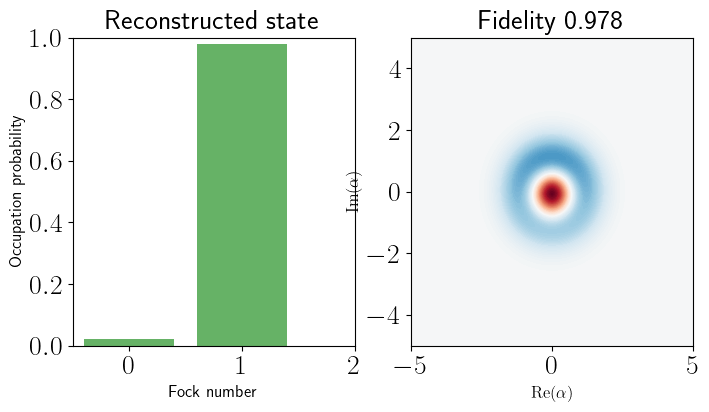

In [227]:
# Define the unknown state as a $N\times N$ Hermitian matrix

X = cp.Variable((N,N), hermitian=True)

#Set the cost function to $\|A\vec\rho - \vec b\|_2$ where the vectorized state is given by `cp.vec(X)`.

cost = cp.norm(A @ cp.vec(X) - b, 2) 

#Set the trace constraint and positive-semidefinite constraint, respectively.
constraints = [cp.trace(X) == 1, X >> 0 ]

#Set up and solve the problem!

prob = cp.Problem(cp.Minimize(cost), constraints)
prob.solve(verbose=False)

# Assign the optimized state X to a Qobj.
reconstructed_rho = Qobj(X.value)

### Visualize results

#Plot the reconstructed state 
alpha_max = 5
fig, ax = plot_wigner_fock_distribution(reconstructed_rho, alpha_max=5)
ax[0].set_title("Reconstructed state")

f=fidelity(reconstructed_rho, initial_cavity)**2
ax[1].set_title("Fidelity %.3f"%(f));

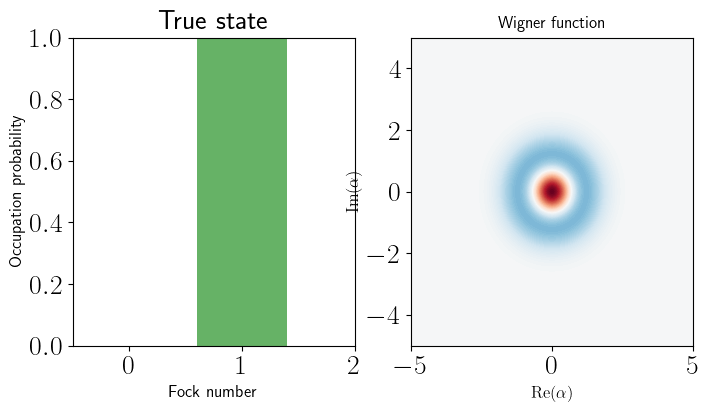

In [228]:
fig, ax = plot_wigner_fock_distribution(initial_cavity, alpha_max=5);
ax[0].set_title("True state");